In [1]:
from financepy.utils import *
from financepy.products.fx import *
from financepy.market.volatility import *
from financepy.market.curves import *

from financepy.utils.date import Date
from financepy.market.curves.discount_curve_flat import *
from financepy.market.volatility.fx_vol_surface import *
from financepy.models.sabr import *

%load_ext autoreload
%autoreload 2

####################################################################
# FINANCEPY BETA Version 0.270 - This build:  13 Feb 2023 at 17:38 #
#      This software is distributed FREE & WITHOUT ANY WARRANTY    #
#  Report bugs as issues at https://github.com/domokane/FinancePy  #
####################################################################



In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Creat option

In [3]:
valuation_date = Date(5, 4, 2023)

In [4]:
forName = "USD"
domName = "JPY"
forCCRate = 0.0381  # USD
domCCRate = 0.000396 # JPY

In [5]:
dom_discount_curve = DiscountCurveFlat(valuation_date, domCCRate)
for_discount_curve = DiscountCurveFlat(valuation_date, forCCRate)

currency_pair = forName + domName
spot_fx_rate = 131.32

expiry_date = valuation_date.add_tenor("10M")

In [6]:
for_discount_curve

OBJECT TYPE: DiscountCurveFlat
FLAT RATE: 0.0381
FREQUENCY: FrequencyTypes.CONTINUOUS
DAY COUNT: DayCountTypes.ACT_ACT_ISDA

In [7]:
currency_pair

'USDJPY'

In [8]:
strike_price = 130

In [9]:
call_option = FXVanillaOption(expiry_date, strike_price, currency_pair, OptionTypes.EUROPEAN_CALL, 70000000, "USD")

In [10]:
print(call_option)

OBJECT TYPE: FXVanillaOption
EXPIRY DATE: 05-FEB-2024
CURRENCY PAIR: USDJPY
PREMIUM CCY: USD
STRIKE FX RATE: 130
OPTION TYPE: OptionTypes.EUROPEAN_CALL
SPOT DAYS: 0
NOTIONAL: 70000000


In [11]:
volatility = 0.1043
alpha = 0.174; beta = -0.929523; rho = -0.5; nu = 0.5
#alpha = 0.17604208;beta=0.89914511;rho= 0.0431321;nu= 0.07451885
model = SABR(alpha,beta,rho,nu)

In [12]:
model

OBJECT TYPE: SABR
Alpha: 0.174
Beta: -0.929523
Nu: 0.5
Rho: -0.5

In [13]:
blackVol = volatility
f = spot_fx_rate
k = strike_price
texp = 0.8444
model.set_alpha_from_black_vol(blackVol,f, k, texp)

131.32
131.32
131.32
131.32


In [14]:
model

OBJECT TYPE: SABR
Alpha: 1229.4041716115478
Beta: -0.929523
Nu: 0.5
Rho: -0.5

In [15]:
model.black_vol(f, k, texp)

131.32


0.10459113277257928

In [20]:
callValue = call_option.value(valuation_date, spot_fx_rate, dom_discount_curve, for_discount_curve, model)

In [21]:
callValue['cash_dom']

253292881.71113104

In [22]:
model_BS = BlackScholes(volatility)
call_option.value(valuation_date, spot_fx_rate, dom_discount_curve, for_discount_curve, model_BS)

{'v': 3.637623769638847,
 'cash_dom': 254633663.8747193,
 'cash_for': 1939031.8601486392,
 'pips_dom': 3.637623769638847,
 'pips_for': 0.00021308042419215816,
 'pct_dom': 0.027981721304914206,
 'pct_for': 0.02770045514498056,
 'not_dom': 9100000000,
 'not_for': 70000000,
 'ccy_dom': 'JPY',
 'ccy_for': 'USD',
 'volatility': 0.1043}

In [23]:
spot_fx_rate = np.linspace(80,200,1000)
callValue1 = call_option.value(valuation_date,spot_fx_rate,dom_discount_curve,for_discount_curve,model_BS)['cash_dom']
callValue2 = [call_option.value(valuation_date,f,dom_discount_curve,for_discount_curve,model)['cash_dom']  for f in spot_fx_rate]
vol_sabr = [call_option.value(valuation_date,f,dom_discount_curve,for_discount_curve,model)['volatility'] for f in spot_fx_rate]

In [24]:
price = []
alphas = []
for f in spot_fx_rate:
    model.set_alpha_from_black_vol(blackVol,f, strike_price, texp)
    alphas.append(model._alpha)
    price.append(int(call_option.value(valuation_date,f,dom_discount_curve,for_discount_curve,model)['cash_dom']))

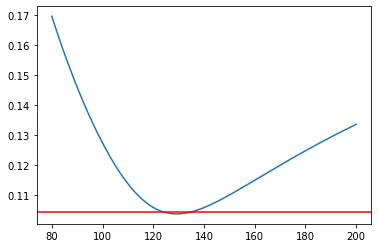

In [25]:
plt.plot(spot_fx_rate,vol_sabr)
plt.axhline(y=model_BS._volatility,c='r')


In [26]:
payoff = [max(0,x-130) for x in spot_fx_rate]

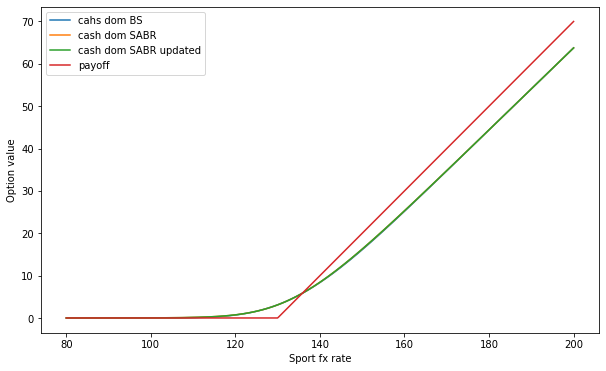

In [27]:
plt.figure(figsize=(10,6))
plt.plot(spot_fx_rate,callValue1/70000000,label = 'cahs dom BS')
plt.plot(spot_fx_rate,np.array(callValue2)/70000000,label='cash dom SABR')
plt.plot(spot_fx_rate,np.array(price)/70000000,label='cash dom SABR updated')
plt.plot(spot_fx_rate,payoff,label = 'payoff')
plt.xlabel('Sport fx rate')
plt.ylabel('Option value')
plt.legend()

## FX Vol surface

In [163]:
tenors = ['9M', '1Y']
atm_vols = [10.79748,10.46629]
msDeltaVols25 = [0.0035,0.0038]
msDeltaVols10 = [0.0126,0.0142]
rrDeltaVols25 = [-0.014,-0.0125]
rrDeltaVols10 = [-0.028,-0.025]

In [170]:
notional_currency = forName
atmMethod = FinFXATMMethod.FWD_DELTA_NEUTRAL
deltaMethod = FinFXDeltaMethod.SPOT_DELTA
alpha = 0.7
spot_fx_rate = 131.32

In [171]:
FXVolSurfaceSABR = FXVolSurfacePlus(valuation_date,
                              spot_fx_rate,
                              currency_pair,
                              notional_currency,
                              dom_discount_curve,
                              for_discount_curve,
                              tenors,
                              atm_vols,
                              msDeltaVols25,rrDeltaVols25,
                              msDeltaVols10,rrDeltaVols10,
                              alpha,
                              atmMethod,
                              deltaMethod,VolFunctionTypes.SABR)

In [172]:
FXVolSurfaceSABR.check_calibration(True)

VALUE DATE: 05-APR-2023
SPOT FX RATE: 131.32
ALPHA WEIGHT: 0.7
ATM METHOD: FinFXATMMethod.FWD_DELTA_NEUTRAL
DELTA METHOD: FinFXDeltaMethod.SPOT_DELTA
TENOR: 9M
EXPIRY DATE: 05-JAN-2024
IN ATM VOL: 10.797480 %
IN MKT STRANGLE 25D VOL:  0.003500 %
IN RSK REVERSAL 25D VOL: -0.014000 %
IN MKT STRANGLE 10D VOL:  0.012600 %
IN RSK REVERSAL 10D VOL: -0.028000 %
T_(YEARS):  0.7534246575342466
CNT_CPD_RD: 0.039600 %
CNT_CPD_RF: 3.810000 %
FWD_RATE:  127.642064
VOL FUNCTION VolFunctionTypes.SABR
VOL_PARAMETERS: [0.61685862 0.64056011 0.14973594 0.07765443]
OUT_K_ATM:  128.203891
OUT_ATM_VOL: 10.794765 %
FAILED FIT TO ATM VOL IN: 10.797480  OUT: 10.794765  DIFF: -0.002715
CALL_DELTA:  0.485842  PUT_DELTA: -0.485860  NET_DELTA: -0.000018
MKT STRANGLE 25D VOL IN:  0.003500 %
K_25D_C_MS: 136.282265  ATM + MSVOL: 10.800980 %   DELTA:  0.250000
K_25D_P_MS: 120.605063  ATM + MSVOL: 10.800980 %   DELTA: -0.250000
CALL_VALUE:  1.769207  PUT_VALUE:  1.944798  MS_VALUE:  3.714005
K_25D_C_MS: 136.282265  SU

In [173]:
strikes = np.linspace(80,200,1000)
expiry_date = valuation_date.add_tenor('1Y')

In [174]:
vol_SABR = []
for k in strikes:
    vol = FXVolSurfaceSABR.volatility_from_strike_date(k,expiry_date)
    vol_SABR.append(vol*100)

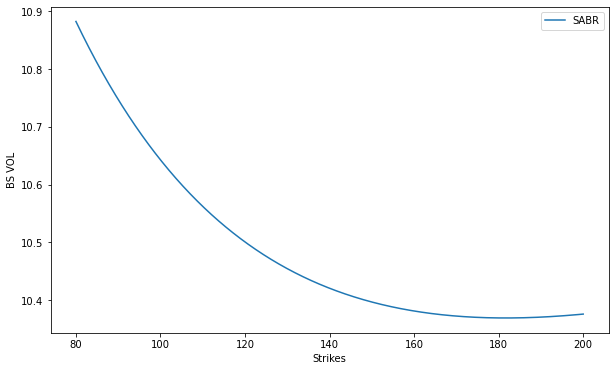

In [175]:
plt.figure(figsize=(10,6))
plt.plot(strikes,vol_SABR,label = 'SABR')
plt.xlabel('Strikes')
plt.ylabel('BS VOL')
plt.legend()

In [60]:
## FXVanilla option pricing with MC
strike = 130
rd = domCCRate
rf = forCCRate
sigma = volatility
s0 = 131.31
t = texp

In [61]:
import random
from scipy.stats import norm
random.seed(2)
nsim = 1000
z = np.random.randn(nsim,1)

In [62]:
A = np.exp((rd-rf-0.5*sigma**2)*texp + sigma*np.sqrt(texp)*z)

In [63]:
init_s0 = [s0]*nsim
df = pd.concat([pd.DataFrame(init_s0).T,pd.DataFrame(A*s0).T],axis=0)
df.index = ["0","1"]

In [64]:
df

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,131.310000,131.310000,131.310000,131.310000,131.310000,131.3100,131.31000,131.310000,131.31000,131.310000,...,131.310000,131.310000,131.310000,131.310000,131.310000,131.310000,131.310000,131.310000,131.310000,131.3100
1,125.536682,129.241558,116.278455,105.885753,116.407495,130.6446,142.24279,119.624285,131.81352,132.545949,...,124.230288,130.880058,130.775428,123.202841,135.063409,128.611322,119.648995,126.976229,112.028856,109.9654


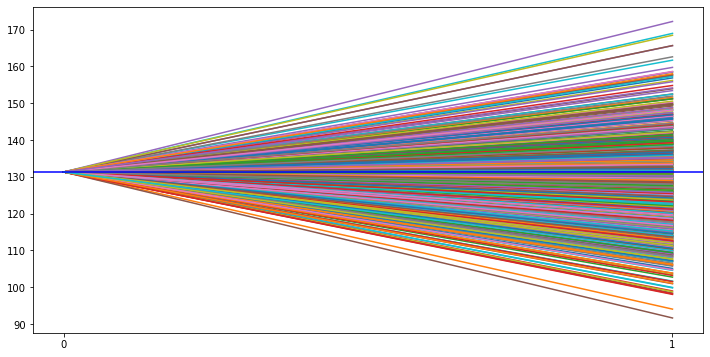

In [65]:
plt.figure(figsize=(12,6))
plt.plot(df)
plt.axhline(s0,c='b')
plt.show()

In [70]:
payoff = [max(0,x) for x in A*s0-strike]

In [77]:
np.array(payoff).mean()

C:\Users\yuanp\AppData\Local\Temp/ipykernel_187116/1412898863.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array(payoff).mean()


array([3.4201429])